In [2]:
import yfinance as yf # to get stock data from yahoo finance | pip install yfinance
import kmapper as km # perfoms mapper algorithm | pip install kmapper
from kmapper.jupyter import display # to display the visual
import umap # to do dimensionality reduction | pip install umap-learn

import sklearn.manifold as manifold # to perfom dimensionality reduction | pip install scikit-learn
import numpy as np # to perfome some calculations and clean data | pip install numpy
import matplotlib.pyplot as plt # to visualize some graphs | pip install matplotlib
from datetime import datetime # to get dates | pip install datetime
from sklearn.preprocessing import StandardScaler # to standarize the data 
from sklearn import cluster # to make the cluster on mapper algorithm

# Importing Data

### Read S&P500 tciker names

In [3]:
file = open("SP500_tickernames.txt", "r") #read de companies you want to consult (495)
ticker_names = file.read().split("\n")[:-1] # split them as a list, ignore last value (is empty)

In [4]:
start_date = '2020-01-01' #from 2020
end_date = datetime.now().date().strftime('%Y-%m-%d') #to date

In [5]:
df = yf.download(ticker_names, start = start_date, end = end_date) #get the data | some may fail

[*********************100%%**********************]  494 of 495 completed

23 Failed downloads:
['PBCT', 'XLNX', 'SIVB', 'ABC', 'PKI', 'VIAC', 'RE', 'ATVI', 'FBHS', 'NLSN', 'CERN', 'DRE', 'NLOK', 'INFO', 'FRC', 'BLL', 'FISV', 'CTXS', 'DISCK', 'ANTM', 'DISCA', 'FB', 'TWTR']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  494 of 495 completed

# Selecting the data

In [6]:
df_closed = df["Adj Close"].dropna(axis = 'columns') #get daily closed prices, drop the others

# Clean the data

In [7]:
scaler = StandardScaler() #initialize the scaler
df_closed[df_closed.columns] = scaler.fit_transform(df_closed[df_closed.columns]) # fit an transform the data

In [8]:
data = df_closed.transpose() #transpose the data

In [9]:
data_per = df["Adj Close"].dropna(axis = 'columns') # this is to calculate the return of every stock

# Calculate a value to show on the analysis (you can use another value)

In [10]:
last_day_of_stock = data_per.transpose().iloc[:, len(data_per.transpose().columns) - 1] # value of the stock on last day
first_day_of_stock = data_per.transpose().iloc[:, 0] #get value of stock on first date

In [11]:
per_return = (last_day_of_stock - first_day_of_stock)/first_day_of_stock #calculate the return of the stock

# Mapper Algorithm

In [12]:
mapper = km.KeplerMapper(verbose=1) #initialize mapper algorithm

KeplerMapper(verbose=1)


# Dimensionality Reduction

In [13]:
projected_data = mapper.fit_transform(data, projection=[manifold.Isomap(n_components=100, n_jobs=-1), # reduce dimension of the data
                                                        umap.UMAP(n_components=2,random_state=1)]) #we can stack multiple algorithms together
# Try different Dimensionality Reduction Algorithms such as tSNE, PCA, or the ones presented here, be creative

..Composing projection pipeline of length 2:
	Projections: Isomap(n_components=100, n_jobs=-1)
		UMAP(random_state=1)
	Distance matrices: False
False
	Scalers: MinMaxScaler()
MinMaxScaler()
..Projecting on data shaped (470, 1026)

..Projecting data using: 
	Isomap(n_components=100, n_jobs=-1)


..Scaling with: MinMaxScaler()

..Projecting on data shaped (470, 100)

..Projecting data using: 
	UMAP(random_state=1, verbose=1)

UMAP(random_state=1, verbose=1)
Wed Jan 31 20:57:12 2024 Construct fuzzy simplicial set


C:\Users\jegomez\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Wed Jan 31 20:57:13 2024 Finding Nearest Neighbors
Wed Jan 31 20:57:15 2024 Finished Nearest Neighbor Search
Wed Jan 31 20:57:18 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Jan 31 20:57:19 2024 Finished embedding

..Scaling with: MinMaxScaler()



# Clusters

In [14]:
G = mapper.map(projected_data, data, clusterer=cluster.DBSCAN(eps = 0.8,min_samples = 2,metric = 'cosine')) 
# Choose your cluster algorithm (KMeans for example, change multiple parameters for each algorithm)
# Try to create a huge variety of edges and nodes (this improves the visualization)

Mapping on data shaped (470, 1026) using lens shaped (470, 2)

Creating 100 hypercubes.

Created 87 edges and 85 nodes in 0:00:00.097095.


# Visualize the results

In [15]:
mapper.visualize(G, 
                path_html="mapper_example.html", #save the map
                title="First_Analysis", #title of the map
                custom_tooltips = df_closed.columns.to_numpy(), # this is to get de stock names
                color_values = np.log(per_return+1), #color of the returns, do as you wish
                color_function_name = 'Log Percent Returns', #name of color
                node_color_function = np.array(['average', 'std', 'sum', 'max', 'min'])) #try different aggregation functions

km.jupyter.display("mapper_example.html") #load the HTML to visualize it

Wrote visualization to: mapper_example.html


C:\Users\jegomez\AppData\Local\anaconda3\Lib\site-packages\IPython\core\display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Try your Own nodes!

Text(0.5, 1.0, 'Stock of cube52_cluster0')

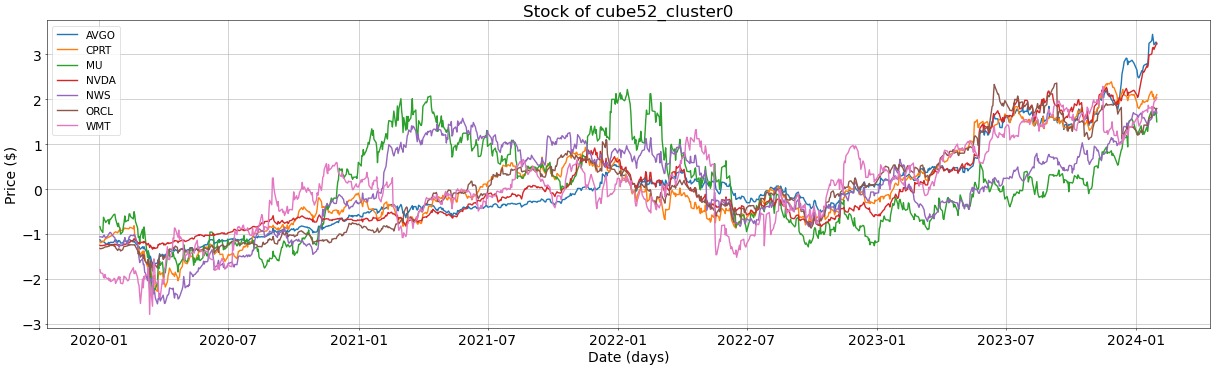

In [28]:
nodeid = 'cube52_cluster0'
node = G['nodes'][nodeid]


plt.figure(figsize=(30, 8), dpi=50)
plt.rcParams.update({'font.size': 20})

for i in node:
    plt.plot(df_closed.iloc[:,i], linewidth=2)
    
plt.legend(list(df_closed.columns[node]), fontsize=15, loc='upper left')
plt.xlabel('Date (days)')
plt.ylabel('Price ($)')
plt.grid()
plt.title('Stock of companies o' + nodeid)